In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

# New Section

# New Section

In [ ]:
!pip install kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:03<00:00, 17.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [ ]:
!kaggle datasets download -d msambare/fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96% 58.0M/60.3M [00:03<00:00, 24.4MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.1MB/s]


In [ ]:
!unzip /content/fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
train_data_directory = '/content/train'
test_data_directory = '/content/test'

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import re
import time
import shutil
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange

#finding files

In [ ]:
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)
validation_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)
train_data = training_data_processor.flow_from_directory(
    train_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)
test_data = validation_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#model building

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for filename in os.listdir(label_path):
                image_path = os.path.join(label_path, filename)
                image_paths.append(image_path)
                labels.append(label)  # The folder name represents the emotion label

            print(f"Loaded {label} images.")

    return image_paths, labels

In [ ]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_data_directory)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

Loaded neutral images.
Loaded sad images.
Loaded fear images.
Loaded disgust images.
Loaded surprise images.
Loaded happy images.
Loaded angry images.


,image,label
0,/content/train/happy/Training_15809476.jpg,happy
1,/content/train/disgust/Training_14064382.jpg,disgust
2,/content/train/neutral/Training_16077397.jpg,neutral
3,/content/train/surprise/Training_67411508.jpg,surprise
4,/content/train/surprise/Training_1353800.jpg,surprise


In [ ]:
test = pd.DataFrame()
test['image'],test['label'] = load_dataset(test_data_directory)
test.head()

Loaded neutral images.
Loaded sad images.
Loaded fear images.
Loaded disgust images.
Loaded surprise images.
Loaded happy images.
Loaded angry images.


,image,label
0,/content/test/neutral/PrivateTest_49758740.jpg,neutral
1,/content/test/neutral/PublicTest_77953887.jpg,neutral
2,/content/test/neutral/PrivateTest_2117908.jpg,neutral
3,/content/test/neutral/PrivateTest_97387362.jpg,neutral
4,/content/test/neutral/PublicTest_78811277.jpg,neutral


In [ ]:
import seaborn as sns

<Axes: xlabel='count', ylabel='label'>

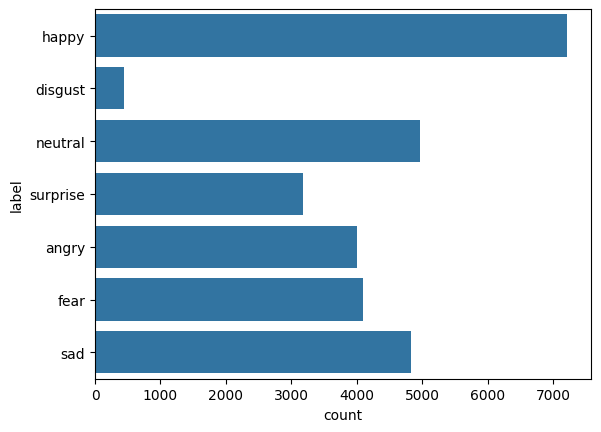

In [ ]:
sns.countplot(train['label'])

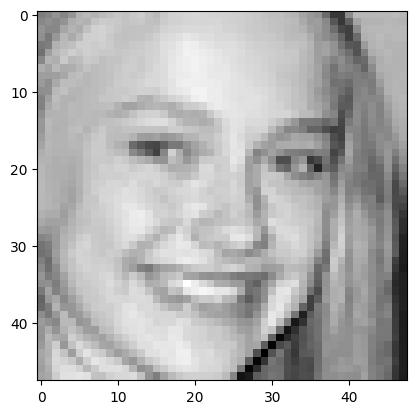

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

In [ ]:
from keras.preprocessing.image import load_img

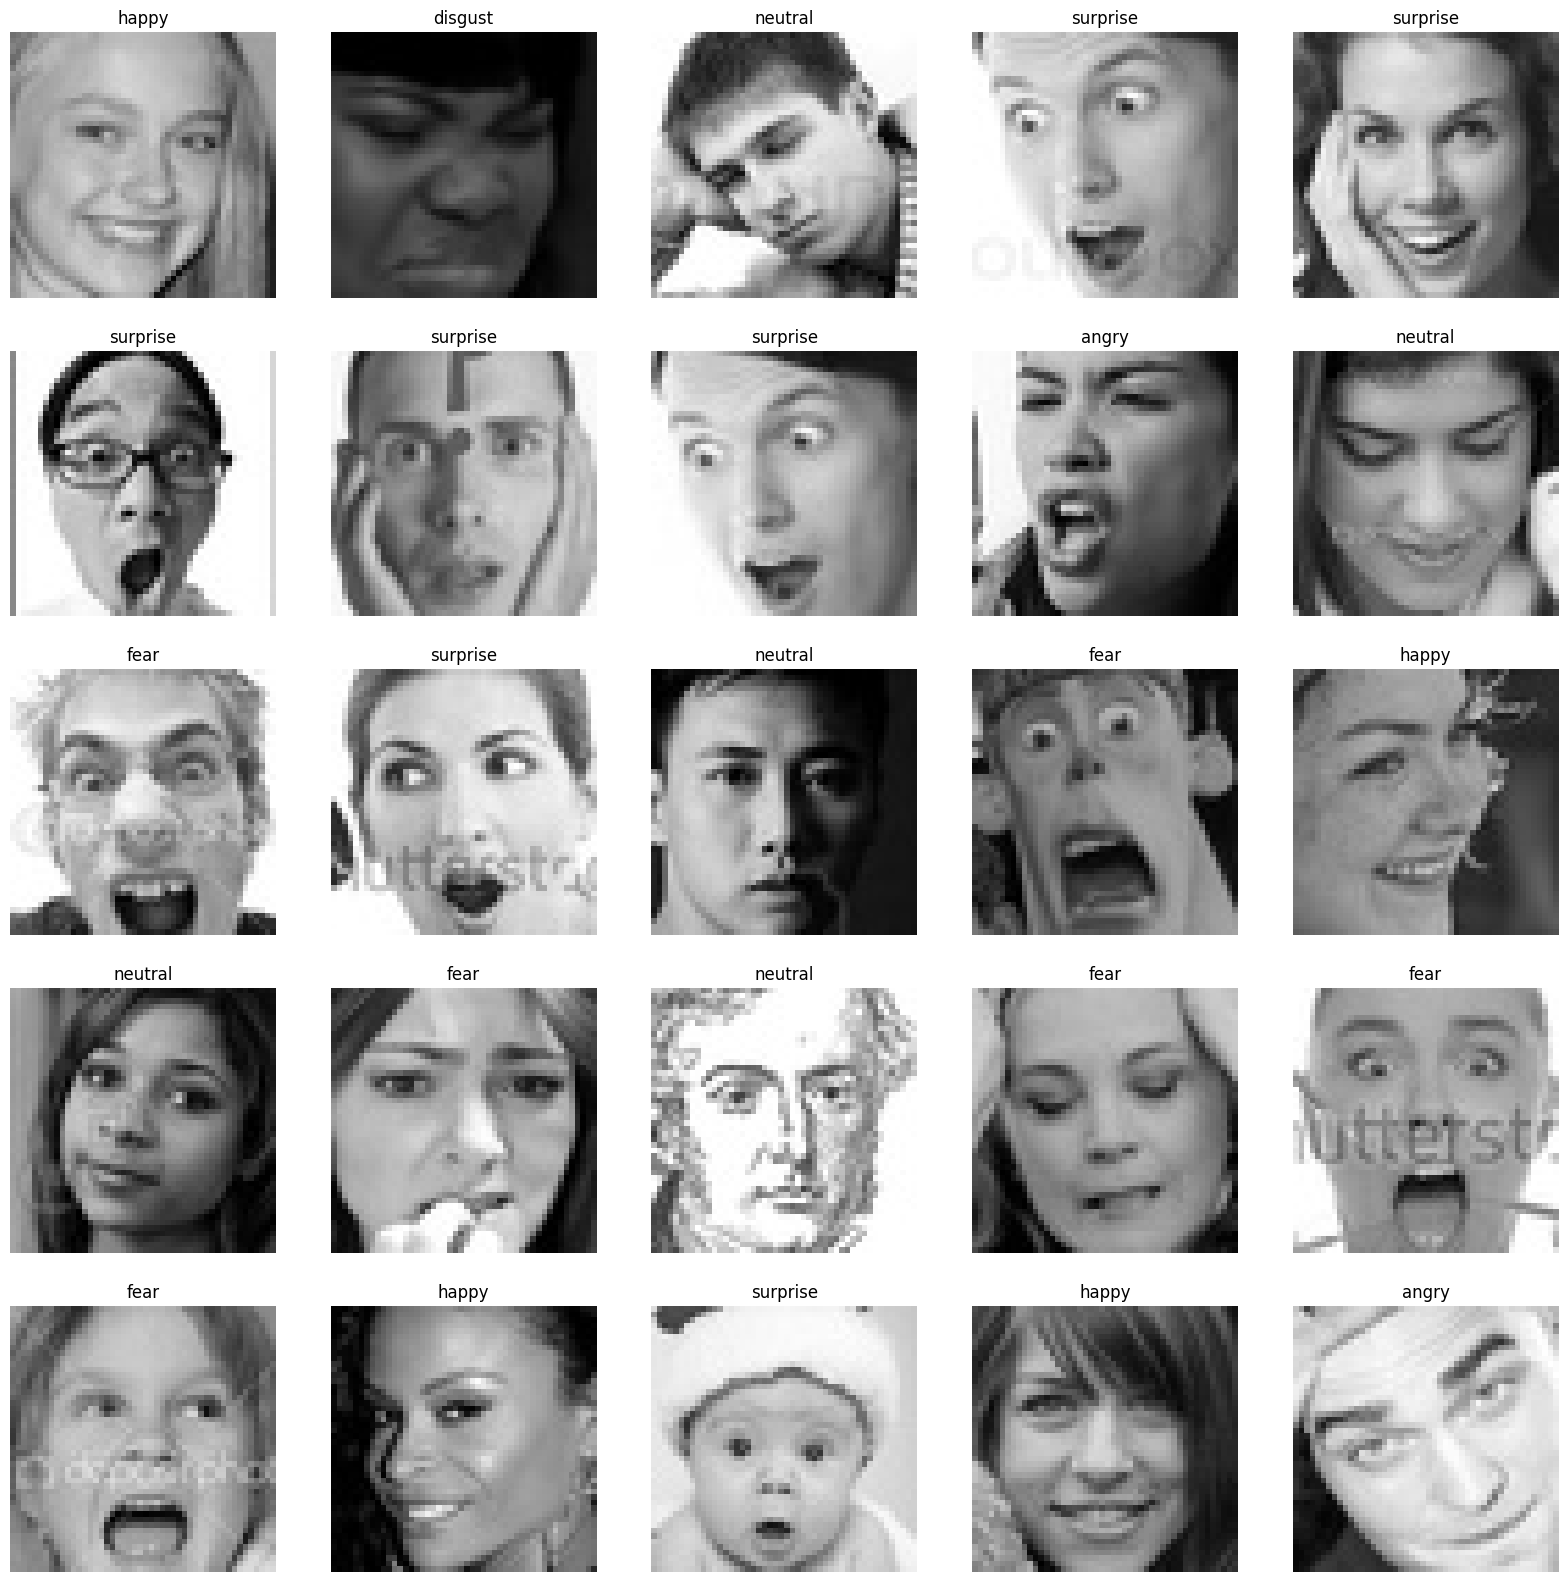

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

#feature extraction

In [ ]:
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from tensorflow.keras.utils import load_img
from keras.layers import Reshape


In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        # Load the image in grayscale mode
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    return features

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
## normalize the image
x_train = np.array(train_features) / 255.0
x_test = np.array(test_features) / 255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])


In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.])

In [ ]:
# config
input_shape = (48, 48, 1)
output_class = 7

#model creation


In [ ]:
# Example architecture with calculated reshaping
model = Sequential()

# Convolutional layers to extract features
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Flatten the output to 2D (needed before passing to LSTM)
model.add(Flatten())

# Now calculate time_steps and features based on the output of flattening
# For example, if after flattening you get 512 units, you may need to reshape it
# to something like (batch_size, time_steps, features), where time_steps and
# features multiply to match the 512 units.

# Instead of hardcoding, calculate the values or use a reshape layer
# Example:
model.add(Reshape((-1, 128)))  # This reshapes the output into (batch_size, time_steps, features)

# LSTM layer
model.add(LSTM(128, return_sequences=False))  # Modify based on your needs
model.add(Dropout(0.5))

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(output_class, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 4,167,175 (15.90 MB)

 Trainable params: 4,167,175 (15.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Specify the percentage of data to use for training and testing (e.g., 20%)
sample_fraction = 0.1

# Reduce the training dataset
num_train_samples = int(len(x_train) * sample_fraction)
train_indices = np.random.choice(len(x_train), num_train_samples, replace=False)
x_train_sample = x_train[train_indices]
y_train_sample = y_train[train_indices]

# Reduce the testing dataset
num_test_samples = int(len(x_test) * sample_fraction)
test_indices = np.random.choice(len(x_test), num_test_samples, replace=False)
x_test_sample = x_test[test_indices]
y_test_sample = y_test[test_indices]

# Display the new dataset sizes
print(f"Original training size: {len(x_train)}")
print(f"Reduced training size: {len(x_train_sample)}")
print(f"Original testing size: {len(x_test)}")
print(f"Reduced testing size: {len(x_test_sample)}")

# Convert to TensorFlow datasets for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_sample, y_train_sample))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_sample, y_test_sample))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

Original training size: 28709
Reduced training size: 2870
Original testing size: 7178
Reduced testing size: 717


In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=164, epochs=100, validation_data=(x_test, y_test))


Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.6676 - loss: 0.9032 - precision: 0.7784 - recall: 0.5494 - val_accuracy: 0.6156 - val_loss: 1.0429 - val_precision: 0.7310 - val_recall: 0.4986
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.6575 - loss: 0.9239 - precision: 0.7745 - recall: 0.5280 - val_accuracy: 0.6121 - val_loss: 1.0520 - val_precision: 0.7302 - val_recall: 0.4978
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.6673 - loss: 0.9024 - precision: 0.7810 - recall: 0.5427 - val_accuracy: 0.6109 - val_loss: 1.0718 - val_precision: 0.7102 - val_recall: 0.5095
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.6743 - loss: 0.8924 - precision: 0.7822 - recall: 0.5510 - val_accuracy: 0.6076 - val_loss: 1.0540 - val_precision: 0.7181 - val_recall: 0.5064
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.6797 - loss: 0.8828 - precision: 0.7871 - recall: 0.5596 - val_accuracy: 0.6215

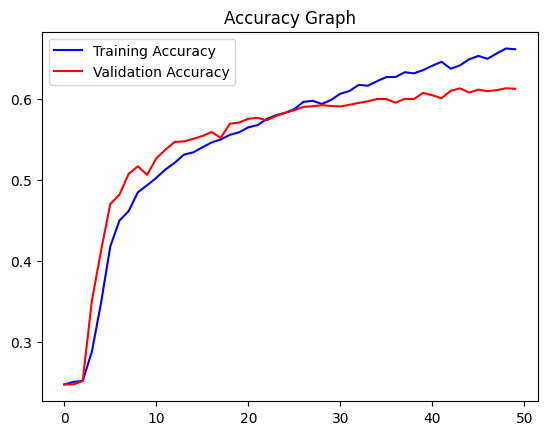

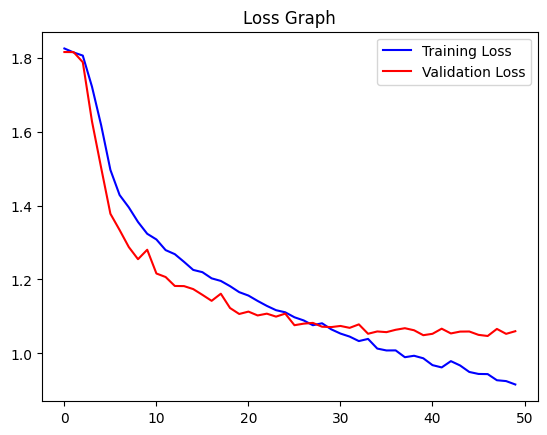

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

Original Output: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Predicted Output: neutral


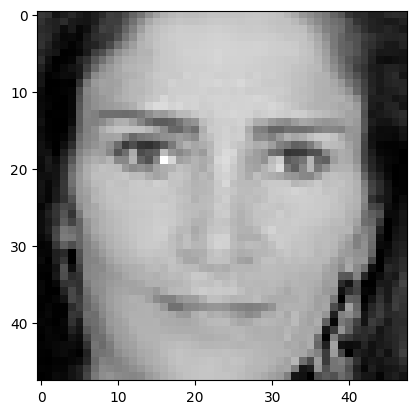

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');